# Load Data

In [1]:
from recom_system.algorithms.preprocessing import get_ratings_datasets


trainset, testset = get_ratings_datasets(train_size=0.8, drop_zero=True)
print(f'{len(trainset.raw_ratings)=}, {len(testset)=}')


len(trainset.raw_ratings)=311390, len(testset)=51709


# Build Model

In [2]:
from recom_system.algorithms.models.svd_nn import SvdNCF


svdncf = SvdNCF(svd_params={'n_factors': 10, 'n_epochs': 20},
                ncf_params={'in_features': 20, 'out_features': 1},
)
%time svdncf.fit(trainset.build_full_trainset())

2024-04-24 22:42:31.296126: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-24 22:42:32.041236: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


CPU times: user 904 ms, sys: 121 µs, total: 904 ms
Wall time: 904 ms


In [3]:
import torch

optimizer = torch.optim.Adam(svdncf.ncf.parameters(), lr=1e-3, weight_decay=1e-4)
loss_func = torch.nn.MSELoss()

losses = svdncf.train(optimizer, loss_func, epochs=20)

20/20: 100%|███████████████████████████████| 3893/3893 [00:16<00:00, 236.16it/s]


Text(0, 0.5, 'mse')

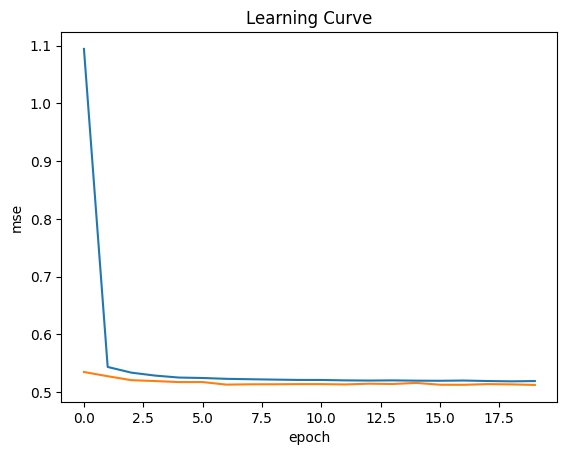

In [4]:
from matplotlib import pyplot as plt

train_loss, test_loss = zip(*losses)
plt.plot(range(len(train_loss)), train_loss, label='train loss')
plt.plot(range(len(test_loss)), test_loss, label='test loss')
plt.title('Learning Curve')
plt.xlabel('epoch')
plt.ylabel('mse')

In [6]:
import pickle
import os
import torch


def save_model(model, path):
    svd = model.svd
    ncf = model.ncf
    path_svd = os.path.join(path, 'svd.pkl')
    path_ncf = os.path.join(path, 'ncf.pt')

    with open(path_svd, 'wb') as f:
        pickle.dump(svd, f)
    torch.save(ncf.state_dict(), path_ncf)
    return (path_svd, path_ncf)

save_model(svdncf, '.')

('./svd.pkl', './ncf.pt')

# Test

In [2]:
from recom_system.algorithms.models.svd_nn import SvdNCF

svdncf = SvdNCF.load('.')

2024-04-24 23:03:36.961700: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-24 23:03:37.731450: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [16]:
from recom_system.algorithms.metrics import evaluate

results_svdncf = evaluate(svdncf, testset, ['rmse', 'ndcg@10', 'precision@20', 'recall@20'])
results_svdncf

{'rmse': 0.8533428325075073,
 'ndcg@10': 0.9927735543250672,
 'precision@20': 0.7470016824246439,
 'recall@20': 0.7974929037555882}

# Train A Classifier

In [5]:
from recom_system.algorithms.models.svd_nn import SvdNCFClf

snclf = SvdNCFClf(svd_params={'n_factors': 10, 'n_epochs': 20},
                    ncf_params={'in_features': 20, 'out_features': 1}, biased=False)
%time snclf.fit(trainset.build_full_trainset())

CPU times: user 833 ms, sys: 4.01 ms, total: 837 ms
Wall time: 837 ms


In [6]:
import torch

optimizer = torch.optim.Adam(snclf.ncf.parameters(), lr=1e-3, weight_decay=1e-4)
loss_func = torch.nn.MSELoss()

losses = snclf.train(optimizer, loss_func, epochs=20)

20/20: 100%|███████████████████████████████| 3893/3893 [00:15<00:00, 255.04it/s]


In [7]:
from recom_system.algorithms.metrics import evaluate

results_snclf = evaluate(snclf, testset, ['ndcg@10', 'precision@20', 'recall@20'])
results_snclf

{'ndcg@10': 0.9926825940658304,
 'precision@20': 0.7470097843140046,
 'recall@20': 0.7975005337834039}